In [102]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import plotly.express as px
import matplotlib as mpl

mpl.rc('font', family='AppleGothic')

In [3]:
df1 = pd.read_csv('14_Data.csv')

In [ ]:
# 파생변수 셋업

In [7]:
df1['방송시작시간_dt'] = pd.to_datetime(df1['방송시작시간'])
df1['방송종료시간_dt'] = pd.to_datetime(df1['방송종료시간'])
df1['방송진행시간'] = (df1['방송종료시간_dt'] - df1['방송시작시간_dt']).dt.total_seconds() / 3600

In [8]:
df1['방송연도'] = df1['방송시작시간_dt'].dt.year
df1['방송월'] = df1['방송시작시간_dt'].dt.month
df1['방송일'] = df1['방송시작시간_dt'].dt.day
df1['방송요일'] = df1['방송시작시간_dt'].dt.day_name()

In [9]:
def func8(row):
    if row['상품주문금액'] >= row['상품목표주문금액']:
        return 1
    else:
        return 0

df1['목표달성여부'] = df1.apply(func8, axis=1)

#### Day15 - 개별미션 마지막 문제

### 9. '목표달성여부'를 분류하는 모델을 만들고자 한다.
    - X : 소요분 / 방송구분 / 판매단가 / ARS 금액 /수수료율 / '방송요일' / '방송월'
    - Y : '목표달성여부'
    - 학습 : 검증 = 8 : 2
    - 특성 공학 기법 (결측처리(평균,최빈값) + 스케일링&인코딩)
    - 알고리즘 (Decision Tree 알고리즘 / 하이퍼파라미터 튜닝 X)
    - 평가

In [10]:
Y = df1['목표달성여부']
X = df1[['소요분', '방송구분', '판매단가', 'ARS금액', '수수료율', '방송요일', '방송월']]

In [15]:
### 필요 라이브러리 불러오기 ###
#학습데이터와 검증 데이터 분할
from sklearn.model_selection import train_test_split
# 학습과 특성공학이 같이 수행되는 파이프라인 구축
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
#특성공학 기법
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
#알고리즘
from sklearn.tree import DecisionTreeClassifier
#교차검증 + 하이퍼 파라미터 튜닝 기법
from sklearn.model_selection import GridSearchCV
# 평가
from sklearn.metrics import classification_report

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=1234)

In [24]:
numeric_list = X.describe().columns # 숫자 데이터 구분 리스트
category_list = X.describe(include = 'object').columns # 문자 데이터 구분 리스트

In [32]:
# 각 데이터 타입 별 파이프라인을 구축
numeric_pipe = make_pipeline(SimpleImputer(strategy = 'mean'), MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                             OneHotEncoder(handle_unknown = 'ignore'))

# handle_unknown = 'ignore' : 학습데이터에 포함되지 않는 항목이 검증데이터나
#                             새로운 데이터에 들어올 때, Unknown 항목으로 처리
preprocess_pipe = make_column_transformer((numeric_pipe, numeric_list),
                                         (category_pipe, category_list))

In [31]:
# 특성공학 + 학습
model_pipe = make_pipeline(preprocess_pipe, DecisionTreeClassifier())
model_pipe.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['소요분', '판매단가', 'ARS금액', '수수료율', '방송월'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['방송구분', '방송요일'], dtype='object'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

# 교차검증

- 학습 단계에서 일반화가 더욱 잘 수행되기 위해, 학습데이터를 여러 단계로 나누어 교차로 검증하는 기법
- Train Set 내에서 Train Data와 Validation Data를 구분하여, 반복적으로 Validation Set을 바꿔가며 학습
- K-Fold Cross Validation : 학습 데이터를 특정 K 개수만큼 나누어, 교차로 검증데이터를 바꿔가며 학습 (k=5 / 5번의 학습이 수행)
- Stratified K-Fold Cross Validation : 학습 데이터를 특정 K 개수만큼 나누는데, 목표변수의 항목의 비율을 고려해서 (분류) K 개수만큼 분할

## Hyper Parameter Tuning

- Hyper Parameter : Model 내 세팅되어있는 수학적인 구조 / 학습 알고리즘에 세팅되어 있는 매개변수
- Hyper Parameter Tuning: 학습 알고리즘 내 매개변수를 사용자가 사전에 조절
- Overfitting 방지 / 학습, 일반화 성능을 효과적으로 올릴 수 있음
    (알고리즘 내 존재하는 Hyper-Parameter를 알고 있어야 함)
    - Random Search : 매개변수의 여러가지 조합을 무작위로 구성해 학습
    - Grid Search : 모든 가능한 매개변수의 조합을 사용자가 직접 구성해 학습
    - Bayesian Optimization : 베이지안 최적화 기법을 이용해, 매개변수를 Gaussian Process 이용하여 모델링 수행 -> 불확실성이 가장 낮은 매개변수를 선택

In [33]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy", "log_loss"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "log_loss" and "entropy" both for the
 |      Shannon information gain, see :ref:`tree_mathematical_formulation`.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to 

In [40]:
# 하이퍼 파라미터 튜닝
# max depth : 5가지 경우의 수 / split 5가지 경우의 수 = 25번
hyperparameter = {'decisiontreeclassifier__max_depth':range(5,11),
                 'decisiontreeclassifier__min_samples_split':range(5,11)}

# 교차검증 3회 x 하이퍼파라미터 튜닝 25회 = 75회 학습 
grid_model = GridSearchCV(model_pipe, param_grid = hyperparameter,
                          cv=3, scoring = 'f1', n_jobs = -1)

# scoring : GridSearch + CV 가장 성능 좋은 모델을 도출함에 있어,
#           성능에 대한 평가 지표를 설정
# n_jobs = -1 : 학습의 연산을 해당 컴퓨터 CPU so ahems Core에게 병렬로 분산
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['소요분', '판매단가', 'ARS금액', '수수료율', '방송월'], dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['방송구분', '방송요일'], dtype='object'))])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': range(5, 11),
                         'decisiontreeclassifier__min_samples_split': range(5, 11)},
             scoring='f1')

In [44]:
best_model = grid_model.best_estimator_

In [45]:
# 평가 함수
def eval_func1(model):
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    print('학습 성능')
    print(classification_report(Y_train, Y_train_pred))
    print('일반화 성능')
    print(classification_report(Y_test, Y_test_pred))

In [46]:
eval_func1(best_model)

학습 성능
              precision    recall  f1-score   support

           0       0.69      0.92      0.79     13042
           1       0.71      0.32      0.44      7984

    accuracy                           0.69     21026
   macro avg       0.70      0.62      0.61     21026
weighted avg       0.70      0.69      0.66     21026

일반화 성능
              precision    recall  f1-score   support

           0       0.68      0.90      0.77      3291
           1       0.62      0.29      0.39      1966

    accuracy                           0.67      5257
   macro avg       0.65      0.59      0.58      5257
weighted avg       0.66      0.67      0.63      5257



## Imbalanced Data Sampling

- 분류모델에 있어, 불균형한 데이터 (Imbalanced Data)의 비율을 맞추어 학습
- Under Sampling : 비율이 많은 쪽의 데이터를 줄여서, 적은 쪽에 맞춰 학습을 수행

In [48]:
df2 = pd.read_csv('12_Data.csv')
df2.head(2) # Diagnosis / B 정상 M 암

,Image ID,Diagnosis,Mean Radius,Mean Perimeter,Mean Area,Mean Texture,Mean Smoothness,Mean Compactness,Mean Concavity,Mean Concave Points,...,SE Radius,SE Perimeter,SE Area,SE Texture,SE Smoothness,SE Compactness,SE Concavity,SE Concave Points,SE Symmetry,SE Fractal Dim
0,842302,M,17.99,122.8,1001.0,10.38,0.12,0.27760,0.3001,0.1471,...,1.0950,8.589,153.40,0.9053,0.0064,0.0490,0.0537,0.0159,0.0300,0.0062
1,842517,M,20.57,132.9,1326.0,17.77,0.08,0.07864,0.0869,0.0702,...,0.5435,3.398,74.08,0.7339,0.0052,0.0131,0.0186,0.0134,0.0139,0.0035


In [49]:
df2['Diagnosis'].value_counts()

Diagnosis
B    357
M    212
Name: count, dtype: int64

In [51]:
# Mean Radius 값과 Mean Concavity 에 따라 M/B 값이 어덯게 바뀌는지 확인
color_mapping = {'M': 'red', 'B':'blue'}
fig1 = px.scatter(df2, x='Mean Radius', y='Mean Concavity',
           color='Diagnosis', color_discrete_map=color_mapping)
fig1 # # Source Data

### **Random UnderSampling** : 무작위로 비율이 많은 쪽의 데이터를 줄여 비율을 조정

In [52]:
from imblearn.under_sampling import RandomUnderSampler

In [56]:
X= df2[['Mean Radius', 'Mean Concavity']]
Y= df2['Diagnosis']

In [57]:
sample_model = RandomUnderSampler()
X_resamp, Y_resamp = sample_model.fit_resample(X,Y)

In [59]:
X_resamp['Target'] = Y_resamp

In [60]:
X_resamp

,Mean Radius,Mean Concavity,Target
0,10.16,0.00503,B
1,8.95,0.09263,B
2,12.47,0.03609,B
3,11.52,0.03036,B
4,12.49,0.00447,B
...,...,...,...
419,20.92,0.31740,M
420,21.56,0.24390,M
421,20.13,0.14400,M
422,16.60,0.09251,M


In [62]:
from plotly.subplots import make_subplots

In [67]:
fig2 = px.scatter(X_resamp, x='Mean Radius', y='Mean Concavity',
          color='Target', color_discrete_map = color_mapping)

In [68]:
# Subplot 생성
figure = make_subplots(rows=1, cols=2, subplot_titles=('Source', 'Resample'))

In [71]:
# 각각의 그래프를 subplot에 추가
def figure_func():
    color_mapping = {'M': 'red', 'B':'blue'}
    fig1 = px.scatter(df2, x='Mean Radius', y='Mean Concavity',
           color='Diagnosis', color_discrete_map=color_mapping)
    fig2 = px.scatter(X_resamp, x='Mean Radius', y='Mean Concavity',
          color='Target', color_discrete_map = color_mapping)
    figure = make_subplots(rows=1, cols=2, subplot_titles=('Source', 'Resample'))
    # 각각의 그래프를 나누어 출력
    for trace in fig1.data:
        figure.add_trace(trace, row=1, col=1)
    for trace in fig2.data:
        figure.add_trace(trace, row=1, col=2)
    figure.show()

In [72]:
figure_func()

In [73]:
Y_resamp.value_counts()

Diagnosis
B    212
M    212
Name: count, dtype: int64

#### **Tomek Link Sampling** : 서로 다른 값이 인접한 데이터를 묶어 비율이 많은 쪽의 데이터를 제거

In [74]:
from imblearn.under_sampling import TomekLinks

In [76]:
sample_model = TomekLinks()
X_resamp, Y_resamp = sample_model.fit_resample(X,Y)
X_resamp['Target'] = Y_resamp

In [77]:
Y_resamp.value_counts()

Diagnosis
B    342
M    212
Name: count, dtype: int64

In [80]:
figure_func()

#### **Edited Nearest Neighbors (ENN)** : 많은 쪽의 데이터를 특정 k개씩 묶어 인접한 데이터를 삭제해 나가며 비율을 맞추는 기법

In [81]:
from imblearn.under_sampling import EditedNearestNeighbours

In [82]:
sample_model = EditedNearestNeighbours()
X_resamp, Y_resamp = sample_model.fit_resample(X,Y)
X_resamp['Target'] = Y_resamp

In [83]:
Y_resamp.value_counts()

Diagnosis
B    294
M    212
Name: count, dtype: int64

In [84]:
figure_func()

- Over Sampling: 비율이 적은 쪽의 데이터를 생성하여 비율을 조정
- **Random Oversampling** : 적은쪽의 데이터를 무작위로 생성

In [85]:
from imblearn.over_sampling import RandomOverSampler

In [86]:
sample_model = RandomOverSampler()
X_resamp, Y_resamp = sample_model.fit_resample(X,Y)
X_resamp['Target'] = Y_resamp

In [87]:
Y_resamp.value_counts()

Diagnosis
M    357
B    357
Name: count, dtype: int64

In [88]:
figure_func()

#### **SMOTE (Synethetic Minority OverSampling Technique)** : 적은 쪽의 데이터를 특정 개수만큼 묶어, 묶인 데이터 사이의 가상의 중심선에 데이터를 생성

In [91]:
from imblearn.over_sampling import SMOTE

In [93]:
sample_model = SMOTE()
X_resamp, Y_resamp = sample_model.fit_resample(X,Y)
X_resamp['Target'] = Y_resamp
Y_resamp.value_counts()

Diagnosis
M    357
B    357
Name: count, dtype: int64

In [94]:
figure_func()

#### **ADASYN (Adaptive Synethic Sampling)** : SMOTE 기법을 보완하여, 생성되는 데이터에 노이즈를 부여해 더욱 사실적인 데이터를 생성

In [95]:
from imblearn.over_sampling import ADASYN

In [96]:
sample_model = ADASYN()
X_resamp, Y_resamp = sample_model.fit_resample(X,Y)
X_resamp['Target'] = Y_resamp
Y_resamp.value_counts()

Diagnosis
M    362
B    357
Name: count, dtype: int64

In [97]:
figure_func()

**Combining Sampling** : Under Sampling + Over Sampling

- SMOTE + Tomek

In [99]:
from imblearn.combine import SMOTETomek

In [100]:
sample_model = SMOTETomek()
X_resamp, Y_resamp = sample_model.fit_resample(X,Y)
X_resamp['Target'] = Y_resamp
Y_resamp.value_counts()

Diagnosis
M    342
B    342
Name: count, dtype: int64

In [103]:
figure_func()

### imbalanced Data Sampling 기법을 적용한 Pipeline 구성

In [104]:
df2 = pd.read_csv('15_Data.csv')
# 정형외과 병원 / 디스크 수술 후 환자들의 데이터

In [107]:
df2['수술실패여부'].value_counts()

수술실패여부
0    1779
1     115
Name: count, dtype: int64

In [108]:
Y = df2['수술실패여부']
X = df2[['연령','체중','신장','수술기법','통증기간(월)','헤모글로빈수치']]

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=1234)

In [110]:
numeric_list = X.describe().columns
category_list = X.describe(include='object').columns

In [116]:
from imblearn.pipeline import make_pipeline

In [117]:
numeric_pipe = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder())

In [120]:
# 파이프라인 구성
preprocess_pipe2 = make_column_transformer((numeric_pipe, numeric_list),
                       (category_pipe, category_list))

In [122]:
model_pipe2 = make_pipeline(preprocess_pipe2, SMOTE(), DecisionTreeClassifier())

In [124]:
grid_model = GridSearchCV(model_pipe2, param_grid=hyperparameter,
            cv=3, n_jobs=-1, scoring='f1')
grid_model.fit(X_train, Y_train)
best_model = grid_model.best_estimator_

In [126]:
eval_func1(best_model)

학습 성능
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1331
           1       0.31      0.78      0.45        89

    accuracy                           0.88      1420
   macro avg       0.65      0.83      0.69      1420
weighted avg       0.94      0.88      0.90      1420

일반화 성능
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       448
           1       0.04      0.12      0.06        26

    accuracy                           0.79       474
   macro avg       0.49      0.47      0.47       474
weighted avg       0.89      0.79      0.84       474



# 개별미션

- 아래의 미션을 Jupyter Notebook으로 풀이 후, [File] - [Download as]에 [HTML (.html] 로 저장하여 메일로 송부해주세요.
- 처음 풀이 시, 40분 정도 구글링이나 ChatGPT없이 풀어주세요.
- 풀이는 다음날 오전에 같이 진행 될 예정입니다.
- 16_Data.csv와 15_Data.csv 데이터를 결합해 아래와 같이 분석을 수행
- ( 두 데이터는 어느 한 정형외과에서 나온 척추 환자 디스크 수술 데이터)
- 15_Data.csv : 수술 후에 측정한 환자의 건강 상태 / 수술 실패여부 / 재발여부 데이터
- 16_Data.csv : 수술 이전에 환자로 부터 수집된 환자 신체정보 데이터

### 1. 15_Data.csv데이터와 16_Data.csv데이터를 가져와 "환자ID"를 기준으로 병합하여, df1 으로 선언하시오.

In [127]:
df_1 = pd.read_csv("15_Data.csv")
df_2 = pd.read_csv("16_Data.csv")

# 데이터 병합
df1 = pd.merge(df_1, df_2, on="환자ID", how="inner")

In [128]:
df1.head(1)

,Column 1,환자ID,수술기법,수술시간,수술실패여부,신장_x,연령_x,재발여부,체중_x,헤모글로빈수치_x,...,종양진행여부,직업,체중_y,헤모글로빈수치_y,혈전합병증여부,환자통증정도_y,흡연여부,통증기간(월)_y,입원일_y,퇴원일_y
0,989,990PT,TELD,50.0,0,171,37,0,68.0,15.1,...,0,공무원,68.0,15.1,0,7,0,16.0,2011-01-20,2011-01-24


---------

### 2. 환자 '성별'에 따라 '통증기간(월)', '헤모글로빈수치'의 평균의 차이가 있는지 검정 하시오.

In [141]:
df2 = df1.dropna()

In [142]:
df_1 = df2[df2['성별']==1]
df_2 = df2[df2['성별']==2]

In [143]:
# 각 집단 별 정규성 검정

# 귀무가설 : 해당 연속형 데이터의 분포는 정규분포를 따른다.
# 대립가설 : 해당 연속형 데이터의 분포는 정규분포를 따르지 않는다.

# 남성그룹
print(stats.normaltest(df_1['통증기간(월)_y']))
# P.value<0.05 / 대립가설 채택 / 정규분포 따르지 않음

print(stats.normaltest(df_1['헤모글로빈수치_y']))
# P.value<0.05 / 대립가설 채택 / 정규분포 따르지 않음

#여성그룹
print(stats.normaltest(df_2['통증기간(월)_y']))
#P.value<0.05/ 대립가설 채택 / 정규분포 따르지 않음

print(stats.normaltest(df_2['헤모글로빈수치_y']))
#P.value<0.05/ 대립가설 채택 / 정규분포 따르지 않음

NormaltestResult(statistic=212.87209145017806, pvalue=5.962284098305776e-47)
NormaltestResult(statistic=10.657564676960133, pvalue=0.004849972042511071)
NormaltestResult(statistic=82.84421484510708, pvalue=1.0247249666234349e-18)
NormaltestResult(statistic=14.593359987070002, pvalue=0.0006777852954622413)


In [145]:
# 정규분포를 따르지 않는(비모수) 집단의 평균의 차이가 있는지 비교

# 귀무가설 : 두 집단의 해당 연속형 자료의 평균은 서로 차이가 없다.
# 대립가설 : 두 집단의 해당 연속형 자료의 평균은 서로 차이가 있다.

# 성별에 따른 '통증기간(월)'
print(stats.ranksums(df_1['통증기간(월)_y'], df_2['통증기간(월)_y']))
# P.value > 0.05 / 귀무가설 채택 / 성별에 따른 통증기간은 서로 차이가 없다.

# 성별에 따른 '헤모글로빈수치'
print(stats.ranksums(df_1['헤모글로빈수치_y'], df_2['헤모글로빈수치_y']))
# P.value < 0.05 / 대립가설 채택 / 성별에 따른 헤모글로빈수치는 서로 차이가 있다.

RanksumsResult(statistic=0.3939123886950358, pvalue=0.6936457234983153)
RanksumsResult(statistic=8.184886160310025, pvalue=2.725611793241031e-16)


---------

### 3. 환자의 '신장'과 '체중'을 이용해 'BMI'수치를 계산하시오.

In [147]:
# BMI= 체중(kg) / 신장(m)^2
# 데이터의 신장은 cm 단위

def calculate_bmi(height_cm, weight_kg):
    height_m = height_cm / 100    # cm -> m
    bmi = weight_kg / (height_m ** 2)
    return bmi

df1['BMI'] = calculate_bmi(df1['신장_x'], df1['체중_x'])

In [149]:
df1.head(2)

,Column 1,환자ID,수술기법,수술시간,수술실패여부,신장_x,연령_x,재발여부,체중_x,헤모글로빈수치_x,...,직업,체중_y,헤모글로빈수치_y,혈전합병증여부,환자통증정도_y,흡연여부,통증기간(월)_y,입원일_y,퇴원일_y,BMI
0,989,990PT,TELD,50.0,0,171,37,0,68.0,15.1,...,공무원,68.0,15.1,0,7,0,16.0,2011-01-20,2011-01-24,23.255019
1,1019,1020PT,TELD,55.0,0,162,27,0,57.0,13.1,...,교사,57.0,13.1,0,8,0,4.0,2011-02-01,2014-03-03,21.719250


-----------

### 4. 환자의 '흡연여부'와 관련 있는 질병을 확인하고자 한다. '간질성폐질환', '고혈압여부', '당뇨여부', '말초동맥질환여부', '빈혈여부', '신부전여부','암발병여부','우울증여부', '종양진행여부', '혈전합병증여부' 항목들 중, 흡연 여부에 대해 유의미한 차이가 있는 질병을 가설 검정을 통해 찾으시오.

In [204]:
from scipy.stats import chi2_contingency

In [213]:
disease = ['간질성폐질환', '고혈압여부', '당뇨여부', '말초동맥질환여부', '빈혈여부', '신부전여부', '암발병여부', '우울증여부', '종양진행여부', '혈전합병증여부']
df_new = df1[['흡연여부'] + disease]
crosstab_1 = pd.crosstab(df_new['흡연여부'], [df_new[d] for d in disease])

In [214]:
# 독립성 검정 (Chi^2 Test)
# 귀무가설 : 두 데이터는 서로 독립이다.
# 대립가설 : 두 데이터는 서로 독립이 아니다.
print(stats.chi2_contingency(crosstab_1))
# P.value>0.05/ 귀무가설 채택 / 두 데이터는 서로 독립이다.

Chi2ContingencyResult(statistic=44.53654327973312, pvalue=0.2866667449240796, dof=40, expected_freq=array([[1.10794351e+03, 2.34899683e+00, 2.34899683e+00, 2.34899683e+01,
        7.82998944e-01, 1.17449842e+01, 7.82998944e-01, 2.58389652e+01,
        7.82998944e-01, 2.34899683e+01, 7.82998944e-01, 3.91499472e+00,
        4.69799366e+01, 7.82998944e-01, 7.82998944e-01, 7.82998944e-01,
        1.56599789e+00, 7.82998944e-01, 3.13199578e+00, 7.82998944e-01,
        7.82998944e-01, 1.37807814e+02, 2.34899683e+00, 3.91499472e+00,
        3.13199578e+00, 3.91499472e+00, 4.69799366e+00, 7.82998944e-01,
        7.82998944e-01, 1.56599789e+00, 2.97539599e+01, 7.82998944e-01,
        7.82998944e-01, 7.82998944e-01, 1.56599789e+00, 2.11409715e+01,
        1.56599789e+00, 2.34899683e+00, 3.13199578e+00, 7.82998944e-01,
        7.82998944e-01],
       [3.07056494e+02, 6.51003168e-01, 6.51003168e-01, 6.51003168e+00,
        2.17001056e-01, 3.25501584e+00, 2.17001056e-01, 7.16103485e+00,
        2.1

------

### 5. 환자의 '직업'중 가장 많은 직업은 어떤 직업이며, 해당 직업 군의 남/여 성비를 확인하시오.

In [151]:
df1['직업'].value_counts().head(1)

직업
사무직    449
Name: count, dtype: int64

In [181]:
df2 = df1[df1['직업']=='사무직']
df2['성별'].value_counts(normalize=True)

성별
1    0.641425
2    0.358575
Name: proportion, dtype: float64

-------

### 6. 수술에 성공했으나, 재발한 환자들의 특성을 살펴보고자 한다. 해당 환자들의 평균연령과 평균 BMI, 남/여 성비의 비율과 직업군의 빈도수를 확인하시오.

In [179]:
# 수술실패여부 (0/1) , 재발여부 (0/1)
cond1 = (df1['수술실패여부']==0)
cond2 = (df1['재발여부']==1)

df3 = df1.loc[cond1&cond2]

mean_age = df3['연령_x'].mean()
mean_bmi = df3['BMI'].mean()
gender_rate = df3['성별'].value_counts(normalize=True)
job_frequent = df3['직업'].value_counts

print("평균 연령:", mean_age)
print("평균 BMI:", mean_bmi)
print("성별 비율:")
print(gender_rate)
print("직업군 빈도수:")
print(job_frequent)

평균 연령: 43.72558139534884
평균 BMI: 25.34985622434419
성별 비율:
성별
1    0.67907
2    0.32093
Name: proportion, dtype: float64
직업군 빈도수:
<bound method IndexOpsMixin.value_counts of 24      의료직
28      NaN
43      자영업
56      NaN
65      사무직
       ... 
1873    노동직
1879     학생
1882    사무직
1887    NaN
1891    사무직
Name: 직업, Length: 215, dtype: object>


-----

### 7. 통증기간과 환자의 통증정도의 상관성이 있는지 가설검정을 수행하여 확인하고, 상관계수를 확인하시오.

In [171]:
df2 = df1.dropna()

In [172]:
# '통증기간(월)_x' , '환자통증정도_x' 간의 상관성?
# 모두 수치형

# 정규성 확인
# 귀무가설 : 해당 연속형 데이터의 분포는 정규분포를 따른다.
# 대립가설 : 해당 연속형 데이터의 분포는 정규분포를 따르지 않는다.
print(stats.normaltest(df2['통증기간(월)_x']))
print(stats.normaltest(df2['통증기간(월)_x']))
# P.value < 0.05 / 대립가설 채택 / 해당 연속형 데이터의 분포는 정규분포를 따르지 않음

NormaltestResult(statistic=306.77252123537926, pvalue=2.427691031686166e-67)
NormaltestResult(statistic=25.17330830422125, pvalue=3.4173192745210406e-06)


In [174]:
# 두 연속형 자료의 상관검정!

# 귀무가설 : 통증기간과 환자통증정도 사이 상관성이 없다.
# 대립가설 : 통증기간과 환자통증정도 사이 상관성이 있다.
stats.spearmanr(df2['통증기간(월)_x'], df2['통증기간(월)_x'])
# P.value<0.05 / 대립가설 채택 / 통증기간과 환자통증정도 사이 상관성이 있다.

SignificanceResult(statistic=1.0, pvalue=0.0)

--------

### 8. 환자의 신장과 체중을 입력했을 때, BMI수치를 계산하고, 해당 연령대의 환자들의 성별에 따른 평균 헤모글로빈수치, 평균 환자통증정도를 시각화하여 출력하는 함수를 생성하시오.

In [198]:
import matplotlib.pyplot as plt

In [195]:
def calculate_age_group(age):
    if age < 30:
        return '20대 이하'
    elif age <= 40:
        return '30대'
    elif age <= 50:
        return '40대'
    elif age <= 60:
        return '50대'
    elif age <=70:
        return '60대'
    else:
        return '고령'
    
df1['Age Group'] = df1['연령_x'].apply(calculate_age_group)

In [237]:
def func8():
    height_cm = int(input('신장(cm)를 입력하세요: '))
    weight_kg = int(input('체중(kg)을 입력하세요: '))
    age = int(input('나이를 입력하세요: '))
    height_m = height_cm / 100    # cm -> m
    bmi = weight_kg / (height_m ** 2)
    print(f'bmi수치는 {bmi}입니다.')
    
    # 해당 연령대의 환자들 필터링
    age_group_df = df1[df1['Age Group'] == calculate_age_group(age)]
    
    # 성별에 따른 평균 헤모글로빈수치 계산
    mean_hemo = age_group_df.pivot_table(index='성별', 
                                        values='헤모글로빈수치_y',
                                        aggfunc='mean')
    
    # 성별에 따른 평균 환자통증정도 계산
    mean_pain = age_group_df.pivot_table(index='성별', 
                                        values='환자통증정도_y',
                                        aggfunc='mean')
    
    # 시각화
    fig, axes = plt.subplots(1, 2)
    
    # 평균 헤모글로빈수치 시각화
    mean_hemo.plot(kind='bar', ax=axes[0])
    axes[0].set_title('평균 헤모글로빈수치')
    
    # 평균 환자통증정도 시각화
    mean_pain.plot(kind='bar', ax=axes[1])
    axes[1].set_title('평균 환자통증정도')
    
    plt.show()

신장(cm)를 입력하세요: 180
체중(kg)을 입력하세요: 70
나이를 입력하세요: 35
bmi수치는 21.604938271604937입니다.


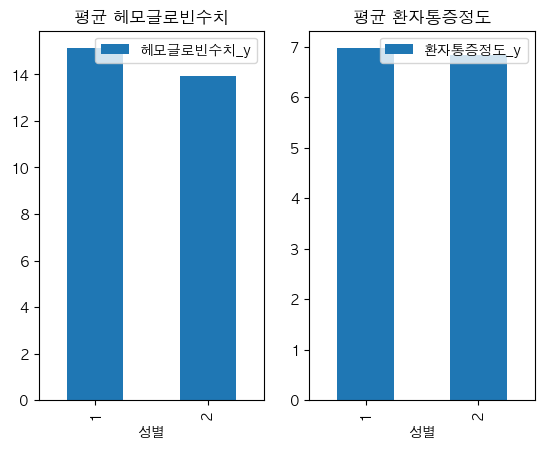

In [238]:
func8()

-----

### 9. 과거에 수술했던 환자들의 특성을 파악하고자 한다. 해당 환자들의 직업군과 성별의 빈도수를 확인하고, 해당 환자들 중 BMI수치가 높은 상위 5명의 환자 명단을 출력하여 recurs_patient.xlsx로 저장하시오.

In [219]:
df1.pivot_table(index='직업', columns='성별',
                aggfunc='size', fill_value=0)

성별,1,2
직업,,
건설업,16,1
공무원,35,16
교사,12,18
군인,74,16
노동직,30,12
농업,29,11
무직,69,95
사무직,288,161
사업가,27,12


In [221]:
df1.nlargest(5, 'BMI').to_excel('recurs_patient.xlsx')

-----

### 10. 수술실패여부를 목표변수로 환자의 기본 특성을 입력했을 때, 해당 환자가 수술을 실패할 지/ 하지 않을지 분류모델을 만들고자 한다. 아래의 조건을 이용해 분류모델을 생성하시오.
    - X값에는 환자의 기본 정보(신체적 정보 + 직업)와 질병력이 포함되어야 합니다.
    - Y값은 "수술실패여부"
    - DecisionTree Classifier를 이용해 학습을 수행하세요.
    - 특성 공학 기법은 자유롭게 적용하여 모델을 구성해 주세요.
    - **단 학습 데이터의 과적합이 발생하면 안되며, 학습 성능 F1 Score 기준 40%이상 나와야 합니다.**
    - 학습한 모델은 model_medical.sav로 저장해 주세요.

In [222]:
df1.columns

Index(['Column 1', '환자ID', '수술기법', '수술시간', '수술실패여부', '신장_x', '연령_x', '재발여부',
       '체중_x', '헤모글로빈수치_x', '환자통증정도_x', '통증기간(월)_x', '혈액형', '수술일', '입원일_x',
       '퇴원일_x', 'Large Lymphocyte', 'Location of herniation', 'ODI', '가족력',
       '간질성폐질환', '고혈압여부', '과거수술횟수', '당뇨여부', '말초동맥질환여부', '빈혈여부', '성별',
       '스테로이드치료', '신부전여부', '신장_y', '심혈관질환', '암발병여부', '연령_y', '우울증여부', '입원기간',
       '종양진행여부', '직업', '체중_y', '헤모글로빈수치_y', '혈전합병증여부', '환자통증정도_y', '흡연여부',
       '통증기간(월)_y', '입원일_y', '퇴원일_y', 'BMI', 'Age Group'],
      dtype='object')

In [223]:
X = df1[['신장_x', '체중_x', '연령_x', '헤모글로빈수치_x', '통증기간(월)_x',
         '직업', '간질성폐질환', '고혈압여부', '당뇨여부', '말초동맥질환여부',
         '빈혈여부', '신부전여부', '암발병여부', '우울증여부', '종양진행여부',
         '혈전합병증여부']]

y = df1['수술실패여부']

In [224]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=1234)

In [225]:
numeric_list = X.describe().columns
category_list = X.describe(include='object').columns

In [227]:
from imblearn.pipeline import make_pipeline

In [228]:
numeric_pipe = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder())

In [229]:
# 파이프라인 구성
preprocess_pipe3 = make_column_transformer((numeric_pipe, numeric_list),
                       (category_pipe, category_list))

In [230]:
model_pipe3 = make_pipeline(preprocess_pipe3, SMOTE(), DecisionTreeClassifier())

In [235]:
grid_model = GridSearchCV(model_pipe3, param_grid=hyperparameter,
            cv=3, n_jobs=-1, scoring='f1')
grid_model.fit(X_train, Y_train)
best_model = grid_model.best_estimator_

In [236]:
eval_func1(best_model)

학습 성능
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1331
           1       0.33      0.71      0.45        89

    accuracy                           0.89      1420
   macro avg       0.65      0.81      0.69      1420
weighted avg       0.94      0.89      0.91      1420

일반화 성능
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       448
           1       0.06      0.15      0.08        26

    accuracy                           0.81       474
   macro avg       0.50      0.50      0.49       474
weighted avg       0.90      0.81      0.85       474

